## 1. Data Description
<ul>
<li>there are 809 training examples</li>
<li>each of them is a dataframe with time, mass , and intensity values</li>
<li>dataframe lenghts are variable</li>
</ul>


In [1]:
import warnings
warnings.filterwarnings('ignore')

# for processing numbers and files csv
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss

# model related
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import tensorflow as tf


In [2]:
# # for working in colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#for gpu
tf.test.is_gpu_available()

False

In [4]:
# for working in kaggle use this paths
kag_path_in = "/kaggle/input/mars-spec-train/"
kag_path_out = "/kaggle/working/"

# # for working in colab  
# kag_path_in = "/content/drive/MyDrive/" # google drive
# kag_path_out = ""

# add custom paths here (uncomment)
# kag_path_in = ""
# kag_path_out = ""

In [5]:
# metadata = pd.read_csv('/kaggle/input/mars-spec-train/metadata.csv').fillna(0)
# train_labels = pd.read_csv('/kaggle/input/mars-spec-train/train_labels.csv')
metadata = pd.read_csv(kag_path_in+'metadata.csv').fillna(0)
train_labels = pd.read_csv(kag_path_in+'train_labels.csv')

## 2. Preprocessing and Feature extraction
<ul>
<li>mass values are grouped into values seperated by 0.50 </li>
<li>time values are grouped into values seperated by 0.02 </li>
<li>Time * Mass matrix (2700,1400) with Intensity values </li>
</ul>

In [6]:
# constants
num_mass_values = 1400
num_time_values = 2700
matrix_shape = (num_time_values, num_mass_values)

In [7]:

# Function to create the Time X Mass matrix for a single data sample
def create_matrix(id):

    sample_id, split, derivate, path, _ = metadata.iloc[id]
    data = pd.read_csv(kag_path_in+path)

    label = None
    if (split == 'train'):
        label = train_labels.iloc[id].values[1:]

    # discretization of time and mass
    data.time = (data.time*50).round()
    data.mass = (data.mass*2).round()
    data.time = data.time.astype(int)
    data.mass = data.mass.astype(int)

    # scaling intensity
    data.intensity = MinMaxScaler().fit_transform(data.intensity.values.reshape(-1, 1))

    # filling matrix
    matrix = np.zeros(matrix_shape)
    matrix[data['time'],data['mass']] = data['intensity']

    return matrix , label


## 3. Data Generation
<ul>
<li>Storing data matrix is costly</li>
<li>data is generated in batches</li>
</ul>


In [8]:
class DataGenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size
    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        low = idx * self.batch_size
        high = min(low + self.batch_size, len(self.data))
        batch_x = []
        batch_y = []

        for i, data_sample in enumerate(self.data[low:high]):
            processed_sample, processed_label = self.preprocess_data(data_sample)
            batch_x.append(processed_sample)
            batch_y.append(processed_label)


        while len(batch_x) < self.batch_size:
            random_no = np.random.randint(0,len(self.data))
            processed_sample, processed_label = self.preprocess_data(data_sample)
            batch_x.append(processed_sample)
            batch_y.append(processed_label)

        return np.array(batch_x), np.array(batch_y)

    def preprocess_data(self, data_sample):
        matrix, label = create_matrix(data_sample)
        if type(label) == np.ndarray:
            label = np.array(label).astype(int)
        return matrix , label


## 4. Model
<ul>
<li>convolutional layers </li>
<li>pooling layers (max pooling) </li>
<li>fully connected layers</li>
<li>sigmoid layer</li>
<li>output positive label probability</li>
</ul>

In [9]:
label_names = [col for col in train_labels.columns[1:]]

In [10]:
# contants
batch_size = 16
num_epochs = 75
model = None
history = None

In [11]:
training_data = range(809)
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
train_data_generator = DataGenerator(train_data, batch_size)
val_data_generator = DataGenerator(val_data, batch_size)
print(len(train_data), len(val_data))

647 162


In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (300,1), padding= 'same',strides = (300,1),activation='relu', input_shape=(num_time_values, num_mass_values, 1)))
model.add(MaxPooling2D(pool_size=(3, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(9, activation='sigmoid'))

opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 1400, 32)       9632      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 700, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 67200)             0         
                                                                 
 dense (Dense)               (None, 256)               17203456  
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 9)                 585       
                                                        

In [13]:
es = EarlyStopping(monitor = 'val_loss', patience = 5 )
history = model.fit(train_data_generator, epochs=num_epochs, validation_data=val_data_generator, callbacks=[es],verbose = 1)

Epoch 1/75
40/40 [==============================] - 376s 9s/step - loss: 0.5476 - auc: 0.4824 - val_loss: 0.3460 - val_auc: 0.5176
Epoch 2/75
40/40 [==============================] - 287s 7s/step - loss: 0.3213 - auc: 0.6899 - val_loss: 0.2701 - val_auc: 0.7679
Epoch 3/75
40/40 [==============================] - 308s 8s/step - loss: 0.2691 - auc: 0.8191 - val_loss: 0.2398 - val_auc: 0.8494
Epoch 4/75
40/40 [==============================] - 343s 9s/step - loss: 0.2392 - auc: 0.8672 - val_loss: 0.2250 - val_auc: 0.8722
Epoch 5/75
40/40 [==============================] - 275s 7s/step - loss: 0.2252 - auc: 0.8827 - val_loss: 0.2162 - val_auc: 0.8821
Epoch 6/75
40/40 [==============================] - 274s 7s/step - loss: 0.2123 - auc: 0.9008 - val_loss: 0.2072 - val_auc: 0.8953
Epoch 7/75
40/40 [==============================] - 352s 9s/step - loss: 0.2050 - auc: 0.9093 - val_loss: 0.2015 - val_auc: 0.9021
Epoch 8/75
40/40 [==============================] - 275s 7s/step - loss: 0.1929 - a

In [14]:
model.save("cnn_model_test.keras")

## 5. Performance
<ul>
<li>train and validation losses</li>
</ul>

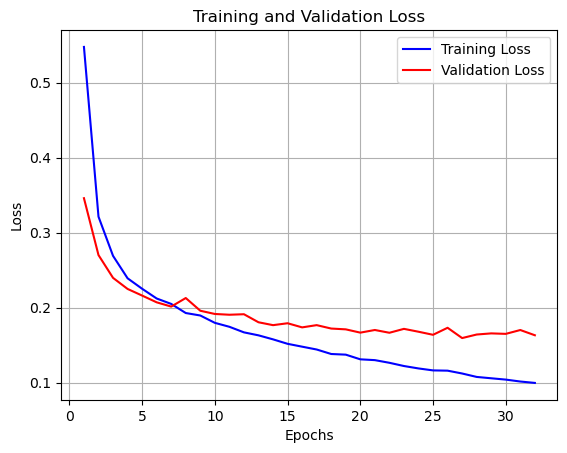

In [15]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()



In [16]:
y_pred = model.predict(DataGenerator(range(809),1), verbose = 0)

### Classification Reports

In [17]:
for i in range(9):
    y_true_column = train_labels.iloc[:, i+1].values
    y_pred_column = y_pred[:, i].round()

    report = classification_report(y_true_column, y_pred_column)
    print(f"{label_names[i]}")
    print(report)
    print(f"roc_auc_score : {roc_auc_score(y_true_column, y_pred[:, i])}")
    print(f"log loss      : {log_loss(y_true_column, y_pred[:, i])}")

    print("-------------------------------------------------------------")


aromatic
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       730
           1       0.90      0.58      0.71        79

    accuracy                           0.95       809
   macro avg       0.93      0.79      0.84       809
weighted avg       0.95      0.95      0.95       809

roc_auc_score : 0.9718744581238079
log loss      : 0.12216185791969722
-------------------------------------------------------------
hydrocarbon
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       544
           1       0.96      0.83      0.89       265

    accuracy                           0.93       809
   macro avg       0.94      0.91      0.92       809
weighted avg       0.93      0.93      0.93       809

roc_auc_score : 0.9755618756936736
log loss      : 0.20582210210718202
-------------------------------------------------------------
carboxylic_acid
              precision    recall  f1-score